### Real time deployment of the machine learning algorithms for predicting the magnetic flux rope structure in coronal mass ejections

This is a code adapted for real time Bz prediction from the Reiss et al. 2021 Space Weather paper.
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021SW002859

This notebook is used for real time deployment.


### Update
last update 2024 Sep 11.

### Ideas

- deploy in real time for data files for STEREO-A and NOAA RTSW  under folder data_path:
"stereoa_beacon_gsm_last_35days_now.p" and "noaa_rtsw_last_35files_now.p"
- read in ML model trained with the notebooks mfrpred_real_bz (done), mfpred_real_btot (need to update)

- continous deployment, look at results during CMEs
- assess progression of results in real time as more of the CME is seen
- needs different trained model for each timestep, i.e. for different hours after sheath and MFR entry?

### Future
- forecast of the cumulative southward Bz during a geomagnetic storm?
- start at time of shock, and then decrease the error bars with time
- correlate with Dst

pattern recognition
https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016SW001589

bz after shocks
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018SW002056

#### Authors: 
M.A. Reiss (1), C. Möstl (2), R.L. Bailey (3), and U. Amerstorfer (2), Emma Davies (2), Eva Weiler (2)

(1) NASA CCMC, 
(2) Austrian Space Weather Office, GeoSphere Austria
(3) Conrad Observatory, GeoSphere Austria


In [34]:
# Python Modules and Packages
import os
import sys
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import cm
import numpy as np
import pickle
from scipy import stats
import scipy.io
import time
import datetime

# Visualisation
import sunpy.time
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from sunpy.time import parse_time

# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

os.system('jupyter nbconvert --to script mfrpred_deploy.ipynb')    

#get data paths
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml



[NbConvertApp] Converting notebook mfrpred_deploy.ipynb to script
[NbConvertApp] Writing 4673 bytes to mfrpred_deploy.py


## load real time data

In [35]:
filenoaa='noaa_rtsw_last_35files_now.p'
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

file_sta_beacon_gsm='stereoa_beacon_gsm_last_35days_now.p'  
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon_gsm, "rb" ) )  

#cutout last 10 days
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta=sta[ind2:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(19967.51245813942, 19977.512458139652)

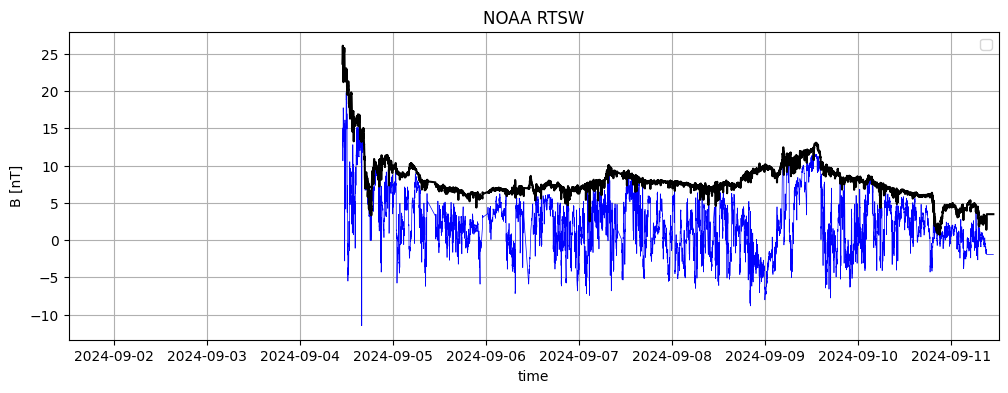

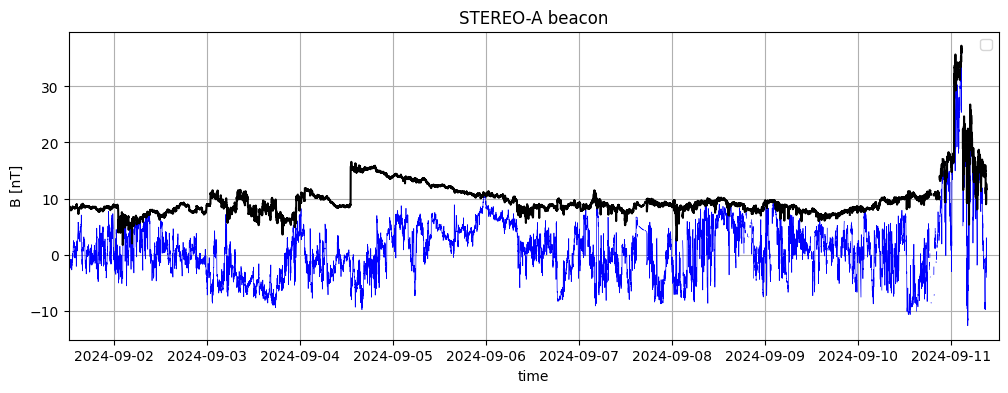

In [36]:
###plot NOAA
plt.figure(1,figsize=(12, 4))
plt.plot(noaa.time,noaa.bz, '-b',lw=0.5)
plt.plot(noaa.time,noaa.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.legend()  # Adding a legend
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4))
plt.plot(sta.time,sta.bz, '-b',lw=0.5)
plt.plot(sta.time,sta.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.legend()  # Adding a legend
plt.grid(True)  # Adding a grid

plt.xlim(start, end)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(19977.097135782544, 19977.513802449954)

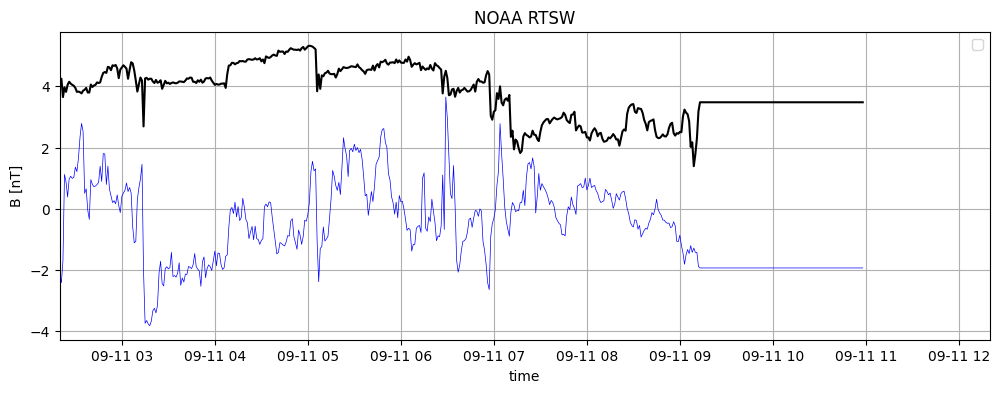

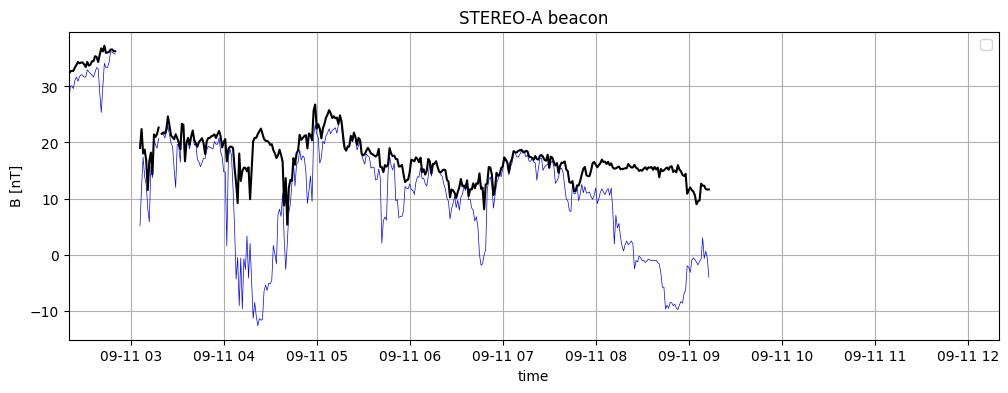

In [38]:
#cutout last 10 hours, e.g. sheath is over and flux rope starts
start=datetime.datetime.utcnow() - datetime.timedelta(hours=10)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa_cut=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta_cut=sta[ind2:]

###plot NOAA
plt.figure(1,figsize=(12, 4))
plt.plot(noaa_cut.time,noaa_cut.bz, '-b',lw=0.5)
plt.plot(noaa_cut.time,noaa_cut.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.legend()  # Adding a legend
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4))
plt.plot(sta_cut.time,sta_cut.bz, '-b',lw=0.5)
plt.plot(sta_cut.time,sta_cut.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.legend()  # Adding a legend
plt.grid(True)  # Adding a grid

plt.xlim(start, end)



### load ML model

In [39]:

#what the model numbers mean
#model1 = models['lr'] 
#model2 = models['rfr'] 
#model3 = models['gbr'] 

feature_hours=10
[model1,model2,model3]=pickle.load(open('trained_models/bz_'+str(feature_hours)+'h_model.p','rb'))

#model1.predict()
model2


#y_pred1 = model1.predict(X_test)

#y_pred1 sind die Bz predictions



RandomForestRegressor(max_depth=5, min_samples_split=4, n_estimators=300)

### Apply ML model


In [40]:
## how to apply, first calculate features from current data? and then put into model

#feature space - map to model, get output



### Make output data files and plots

### General Bz overview plots